In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
df = pd.read_csv(r'data/MSFT-5.csv')

In [3]:
from datetime import datetime
con=df['Date']
df['Date']=pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
#check datatype of index
df.index

DatetimeIndex(['2015-10-12', '2015-10-13', '2015-10-14', '2015-10-15',
               '2015-10-16', '2015-10-19', '2015-10-20', '2015-10-21',
               '2015-10-22', '2015-10-23',
               ...
               '2020-09-28', '2020-09-29', '2020-09-30', '2020-10-01',
               '2020-10-02', '2020-10-05', '2020-10-06', '2020-10-07',
               '2020-10-08', '2020-10-09'],
              dtype='datetime64[ns]', name='Date', length=1259, freq=None)

In [4]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day

In [5]:
# Display a random sampling of 5 rows
df.sample(5, random_state=0)

,Open,High,Low,Close,Adj Close,Volume,year,month,day
Date,,,,,,,,,
2015-10-19,47.419998,47.880001,47.020000,47.619999,43.276833,29387600,2015,10,19
2017-09-27,73.550003,74.169998,73.169998,73.849998,70.616386,19565100,2017,9,27
2015-12-24,55.860001,55.959999,55.430000,55.669998,50.933643,9558500,2015,12,24
2019-09-12,137.850006,138.419998,136.869995,137.520004,135.972031,27010000,2019,9,12
2016-07-08,51.730000,52.360001,51.549999,52.299999,48.531006,28391000,2016,7,8


<AxesSubplot:title={'center':'Closing Prices(Monthwise)'}, xlabel='Date'>

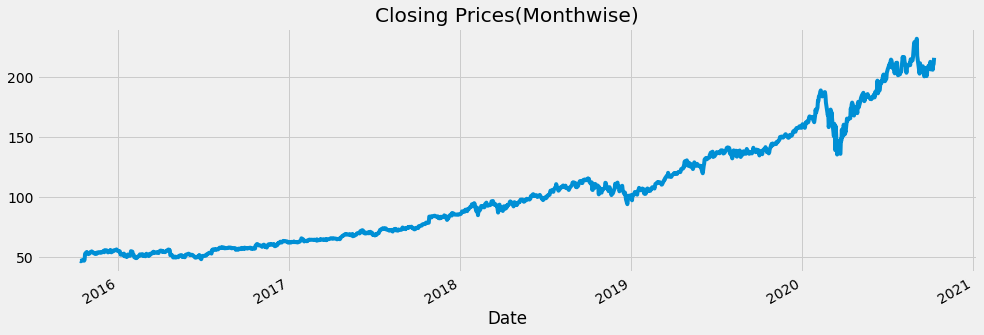

In [6]:
temp=df.groupby(['Date'])['Close'].mean() 
temp.plot(figsize=(15,5), title= 'Closing Prices(Monthwise)', fontsize=14)

<AxesSubplot:xlabel='month'>

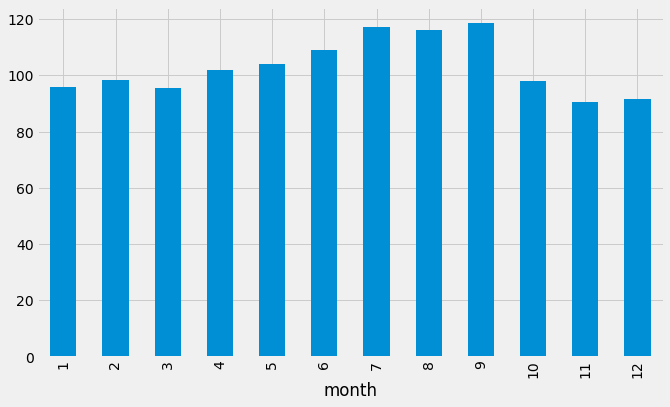

In [7]:
df.groupby('month')['Close'].mean().plot.bar()

In [8]:
test = df[1029:]
train = df[:1028]

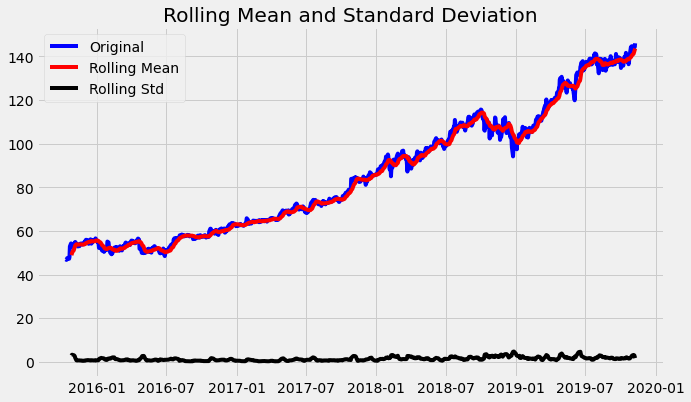

Results of dickey fuller test
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [9]:
#Auto Regression Integrated Moving Average. It is specified by three ordered parameters (p,d,q).
# Before building an ARIMA model, we have to make sure our data is stationary.
# There are three basic criterion for a series to be classified as stationary series :
#The mean of the time series should not be a function of time. It should be constant.
#The variance of the time series should not be a function of time.
#The covariance of the ith term and the (i+m)th term should not be a function of time.

#Steps to make our data stationary.
#We use Dickey Fuller test to check the stationarity of the series.
#The null hypothesis of the test is that time series is not stationary (has some time-dependent structure).
#The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

def test_stationarity(timeseries):
 #Determing rolling statistics
 rolmean = timeseries.rolling(12).mean()
 rolstd = timeseries.rolling(12).std()
 #Plot rolling statistics:
 plt.plot(timeseries, color='blue',label='Original')
 plt.plot(rolmean, color='red', label='Rolling Mean')
 plt.plot(rolstd, color='black', label = 'Rolling Std')
 plt.legend(loc='best')
 plt.title('Rolling Mean and Standard Deviation')
 plt.show(block=False)
 
 print("Results of dickey fuller test")
 adft = adfuller(timeseries,autolag='AIC')
 # output for dft will give us without defining what the values are.
 #hence we manually write what values does it explains using a for loop
 output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
 for key,values in adft[4].items():
    print('\t%s: %.3f' % (key, values))
    
test_stationarity(train['Close'])
 

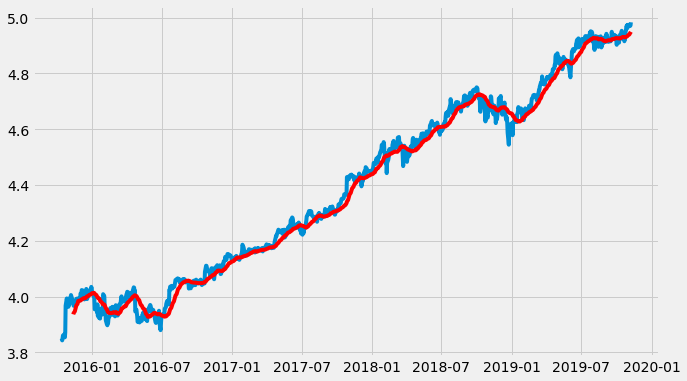

In [10]:
#Making the time series stationary
#To make the series stationary, we remove the trend and seasonality from the data. The resultant series will become stationary through this process.
train_log = np.log(train['Close']) 
test_log = np.log(test['Close'])
moving_avg = train_log.rolling(24).mean() 
plt.plot(train_log) 
plt.plot(moving_avg, color = 'red') 
plt.show()

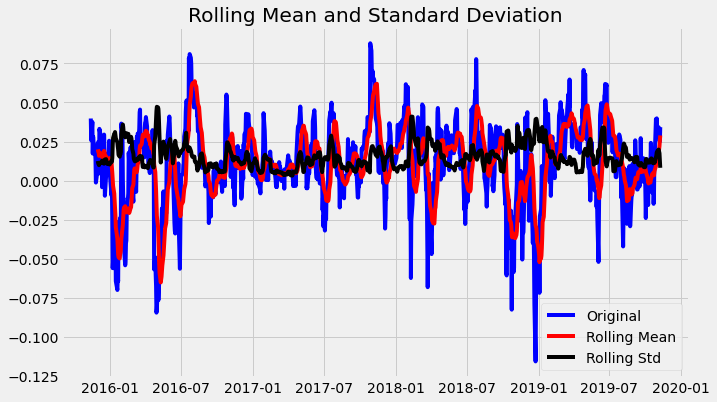

Results of dickey fuller test
	1%: -3.437
	5%: -2.864
	10%: -2.568


(None, None)

In [11]:
#So we can observe that there is a trend. Now we will remove this trend to make our time series stationary.
train_log_moving_avg_diff = train_log - moving_avg
train_log_moving_avg_diff.dropna(inplace = True), test_stationarity(train_log_moving_avg_diff)

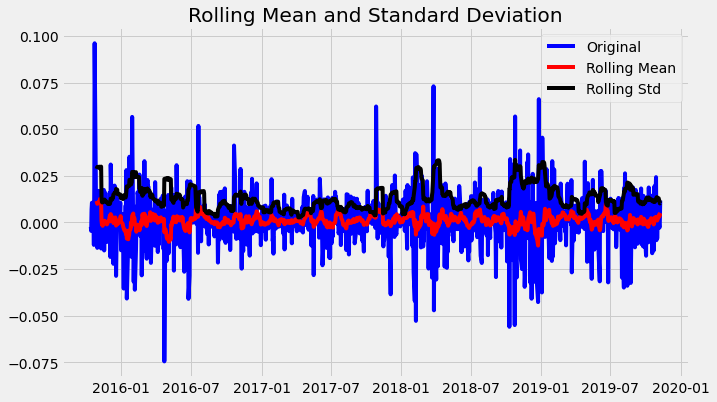

Results of dickey fuller test
	1%: -3.437
	5%: -2.864
	10%: -2.568


In [12]:
#Let’s now stabilize the mean of the time series which is also a requirement for a stationary time series.
#Differencing can help to make the series stable and eliminate the trend.
train_log_diff = train_log - train_log.shift(1) 
test_stationarity(train_log_diff.dropna())

In [13]:
#Removing Seasonality
#By seasonality, we mean periodic fluctuations. A seasonal pattern exists when a series is influenced by seasonal factors (e.g., the quarter of the year, the month, or day of the week).
#We will use seasonal decompose to decompose the time series into trend, seasonality and residuals.


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-5832.059, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5816.639, Time=0.33 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5827.463, Time=0.83 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5829.978, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5812.479, Time=0.22 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-5833.757, Time=0.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-5834.858, Time=0.54 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-5833.229, Time=0.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5832.647, Time=0.83 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-5831.275, Time=0.48 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-5827.208, Time=0.22 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 5.877 seconds


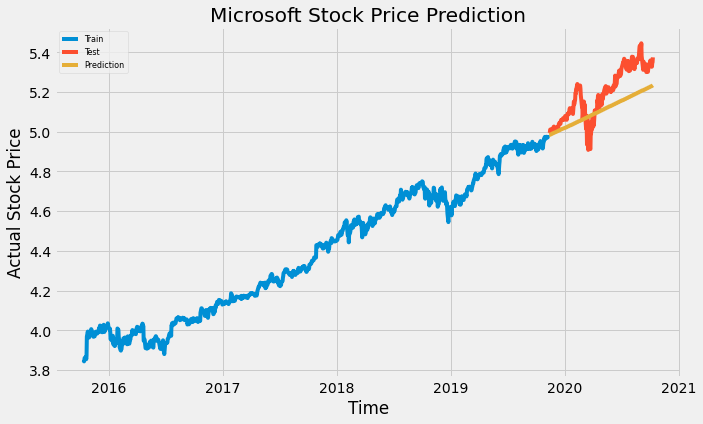

In [14]:
from pmdarima import auto_arima
model = auto_arima(train_log, trace=True, error_action='ignore', suppress_warnings=True)
model.fit(train_log)
forecast = model.predict(n_periods=len(test))
forecast = pd.DataFrame(forecast,index = test_log.index,columns=['Prediction'])
#plot the predictions for validation set
plt.plot(train_log, label='Train')
plt.plot(test_log, label='Test')
plt.plot(forecast, label='Prediction')
plt.title('Microsoft Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [15]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rms = sqrt(mean_squared_error(test_log,forecast))
print("RMSE: ", rms)

RMSE:  0.1133613768127755
